In [1]:
# various import statements
import os
import sklearn
from sklearn import cluster
import pandas as pd
import scanpy as sc
import scvi
import inspect
import tqdm
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.optim
from pyro.infer import SVI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

sc.settings.figdir=os.path.expanduser('~/WbFigures/SpeciesDivergenceNoScaling')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

cuda:0


In [2]:
# adata=sc.read_h5ad(os.path.expanduser('/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination.h5ad'),backed='r')
# adata=adata[~adata.obs['dataset'].isin(['jorstad_cross_areal','krienen_marmoset']),:]
# adata.write_h5ad(os.path.expanduser('/home/matthew.schmitz/Matthew/data/cortex_data/v1_combination_nojo.h5ad'))

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


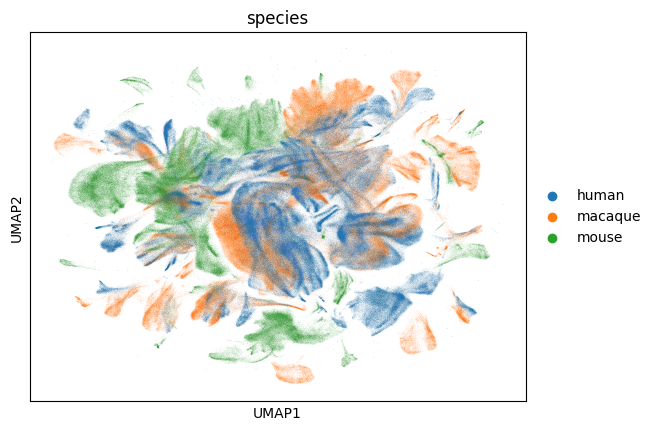

In [3]:
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall.h5ad'),backed='r')
#adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_part0.h5ad'),backed='r')

adata.obsm["X_original_umap"]=adata.obsm["X_umap"]
sc.pl.umap(adata,color='species')

In [4]:
import sys
sys.path.append('/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/')
import antipode_model
from antipode_model import *
import model_functions
from model_functions import *
import model_distributions
from model_distributions import *
import model_modules
from model_modules import *
import train_utils
from train_utils import *
import plotting
from plotting import *

import importlib
antipode_model=importlib.reload(antipode_model)
from antipode_model import *

import importlib
model_modules=importlib.reload(model_modules)
from model_modules import *

model_functions=importlib.reload(model_functions)
from model_functions import *

import importlib
model_distributions=importlib.reload(model_distributions)
from model_distributions import *

import importlib
train_utils=importlib.reload(train_utils)
from train_utils import *

import importlib
plotting=importlib.reload(plotting)
from plotting import *



In [12]:
class AntipodeTrainingMixin:
    '''
    Mixin class providing functions to actually run ANTIPODE
    can use supervised taxonomy by training only phase2
    '''
    
    def save_params_to_uns(self,prefix=''):
        pstore=param_store_to_numpy()
        pstore={n:pstore[n] for n in pstore.keys() if not re.search('encoder|classifier|\$\$\$',n)}
        self.adata_manager.adata.uns[prefix+'param_store']=pstore

    def get_antipode_outputs(self,batch_size=2048,device='cuda'):
        if 'species_onehot' not in self.adata_manager.adata.obsm.keys():
            self.adata_manager.adata.obsm['species_onehot']=numpy_onehot(self.adata_manager.adata.obs['species'].cat.codes)
        self.adata_manager.register_new_fields([scvi.data.fields.ObsmField('species_onehot','species_onehot')])
    
        field_types={"s":np.float32,"species_onehot":np.float32}
        dataloader=scvi.dataloaders.AnnDataLoader(self.adata_manager,batch_size=32,drop_last=False,shuffle=False,data_and_attributes=field_types)#supervised_field_types for supervised step 
        encoder_outs=batch_output_from_dataloader(dataloader,self.zl_encoder,batch_size=batch_size,device=device)
        encoder_outs[0]=self.z_transform(encoder_outs[0])
        encoder_out=[x.detach().cpu().numpy() for x in encoder_outs]
        classifier_outs=batch_torch_outputs([(self.z_transform(encoder_outs[0]))],self.classifier,batch_size=batch_size,device='cuda')
        classifier_out=[x.detach().cpu().numpy() for x in classifier_outs]
        return encoder_out,classifier_out
    
    def store_outputs(self,device='cuda',prefix=''):
        self.save_params_to_uns(prefix='')
        self.to('cpu')
        self.eval()
        antipode_outs=self.get_antipode_outputs(batch_size=2048,device=device)
        taxon=antipode_outs[1][0]
        self.adata_manager.adata.obsm[prefix+'X_antipode']=antipode_outs[0][0]
        self.adata_manager.adata.obs[prefix+'psi']=antipode_outs[1][1]
        level_edges=[numpy_hardmax(self.adata_manager.adata.uns['param_store']['edges_'+str(i)],axis=-1) for i in range(len(self.level_sizes)-1)]
        levels=self.tree_convergence_bottom_up.just_propagate(scipy.special.softmax(taxon[...,-self.level_sizes[-1]:],axis=-1),level_edges,s=torch.ones(1))
        prop_taxon=np.concatenate(levels,axis=-1)
        self.adata_manager.adata.obsm['taxon_probs']=prop_taxon
        levels=self.tree_convergence_bottom_up.just_propagate(numpy_hardmax(levels[-1],axis=-1),level_edges,s=torch.ones(1))
        for i in range(len(levels)):
            cur_clust=prefix+'level_'+str(i)
            self.adata_manager.adata.obs[cur_clust]=levels[i].argmax(1)
            self.adata_manager.adata.obs[cur_clust]=self.adata_manager.adata.obs[cur_clust].astype(str)
        self.adata_manager.adata.obs[prefix+'antipode_cluster'] = self.adata_manager.adata.obs.apply(lambda x: '_'.join([x[prefix+'level_'+str(i)] for i in range(len(levels))]), axis=1)
        self.adata_manager.adata.obs[prefix+'antipode_cluster'] = self.adata_manager.adata.obs[prefix+'antipode_cluster'].astype(str)

    def fix_scale_factor(self,svi,x,ideal_val=0.1):
        o1=svi.evaluate_loss(*x)
        s1=self.scale_factor
        s2=ideal_val*s1/o1
        self.scale_factor=s2

    def prepare_phase_2(self,cluster='kmeans'):
        '''Run this if not running in supervised only mode (JUST phase2 with provided obsm clustering), 
        runs kmeans if cluster=kmeans, else uses the obs column provided by cluster'''
        if cluster=='kmeans':
            kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=self.level_sizes[-1],init='k-means++',max_iter=1000,reassignment_ratio=0.001,n_init=100,random_state=0).fit(self.adata_manager.adata.obsm['X_antipode'])
            self.adata_manager.adata.obs['kmeans']=kmeans.labels_
            self.adata_manager.adata.obs['kmeans']=self.adata_manager.adata.obs['kmeans'].astype(int).astype('category')
            self.adata_manager.adata.obsm['kmeans_onehot']=numpy_onehot(self.adata_manager.adata.obs['kmeans'].cat.codes,num_classes=self.level_sizes[-1])
        else:
            self.adata_manager.adata.obs[cluster]=self.adata_manager.adata.obs[cluster].astype('category')
            self.adata_manager.adata.obsm[cluster+'_onehot']=numpy_onehot(self.adata_manager.adata.obs[cluster].cat.codes,num_classes=self.level_sizes[-1])
        
        self.adata_manager.register_new_fields([make_field('taxon',('obsm',cluster+'_onehot'))])
        kmeans_means=group_aggr_anndata(self.adata_manager.adata,[cluster], agg_func=np.mean,layer='X_antipode',obsm=True)[0]
        new_locs=torch.concatenate(
            [pyro.param('locs').new_zeros(sum(self.level_sizes[:-1]),pyro.param('locs').shape[1]),
             torch.tensor(kmeans_means-kmeans_means.mean(0),device=pyro.param('locs').device).float()],
             axis=0).float()
        new_locs[0,:]=torch.tensor(kmeans_means.mean(0)).float()
        self.adata_manager.adata.obs[cluster].astype(int)
        new_scales=group_aggr_anndata(self.adata_manager.adata,[cluster], agg_func=np.std,layer='X_antipode',obsm=True)[0]
        new_scales=torch.concatenate(
            [0.0001*self.scale_init_val*new_locs.new_ones(sum(self.level_sizes[:-1]),pyro.param('locs').shape[1],requires_grad=True),
             torch.tensor(new_scales+1e-10,device=pyro.param('scales').device,requires_grad=True)],axis=0).float()
        self.adata_manager.adata.obs[cluster].astype(str)
        pyro.get_param_store().__setitem__('locs',new_locs)
        pyro.get_param_store().__setitem__('locs_dynam',new_locs.new_zeros(new_locs.shape))
        pyro.get_param_store().__setitem__('scales',new_scales)
        self.adata_manager.adata.obs[cluster]=self.adata_manager.adata.obs[cluster].astype(str)
    
    def common_training_loop(self, dataloader, max_steps, scheduler, svi, print_every, device, steps=0):
        self.losses = []
        pbar = tqdm.tqdm(total=max_steps, position=0)
        while steps < max_steps:
            for x in dataloader:
                x['step'] = torch.ones(1).to(device) * steps
                x = [x[k].to(device) if k in x.keys() else torch.zeros(1) for k in self.args]
                if self.scale_factor == 1.:
                    self.fix_scale_factor(svi, x)
                pbar.update(1)
                loss = svi.step(*x)
                steps += 1
                if hasattr(scheduler, 'step'):
                    scheduler.step()
                if steps >= max_steps - 1 :
                    break
                
                self.losses.append(loss)
                if steps % print_every == 0:
                    pbar.write(f"[Step {steps:02d}]  Loss: {np.mean(self.losses[-print_every:]):.5f}")
        pbar.close()
        try:
            self.allDone()
        except:
            pass

    def setup_scheduler(self, max_learning_rate, max_steps, one_cycle_lr):
        if one_cycle_lr:
            return pyro.optim.OneCycleLR({
                'max_lr': max_learning_rate,
                'total_steps': max_steps,
                'div_factor': 100,
                'optim_args': {},
                'optimizer': torch.optim.Adam
            })
        else:
            return pyro.optim.ClippedAdam({
                'lr': max_learning_rate,
                'lrd': (1 - (5e-6))
            })

    def train_phase(self, phase, max_steps, print_every=10000, device='cuda', max_learning_rate=0.001, num_particles=1, one_cycle_lr=True, steps=0, batch_size=32,freeze_encoder=None):
        self.scale_factor=1.
        freeze_encoder = True if freeze_encoder is None and phase == 2 else freeze_encoder
        freeze_encoder = False if freeze_encoder is None else  freeze_encoder
        self.set_freeze_encoder(freeze_encoder) 
        supervised_field_types=self.field_types.copy()
        supervised_fields=self.fields.copy()
        supervised_field_types["taxon"]=np.float32
        field_types=self.field_types if phase != 2 else supervised_field_types
        dataloader = scvi.dataloaders.AnnDataLoader(self.adata_manager, batch_size=batch_size, drop_last=True, shuffle=True, data_and_attributes=field_types)
        scheduler = self.setup_scheduler(max_learning_rate, max_steps, one_cycle_lr)
        if phase == 1:
            elbo_class = pyro.infer.JitTrace_ELBO
        else:
            elbo_class = pyro.infer.JitTraceEnum_ELBO
        elbo = elbo_class(num_particles=num_particles, strict_enumeration_warning=False)
        hide_params=[name for name in pyro.get_param_store() if re.search('encoder',name)]
        guide=self.guide if not self.freeze_encoder else poutine.block(self.guide,hide=hide_params)
        svi = SVI(self.model, guide, scheduler, elbo)  
        self.train()
        self.zl_encoder.eval() if self.freeze_encoder else self.zl_encoder.train()
        self = self.to(device)
        self.set_approx(phase == 1)
        return self.common_training_loop(dataloader, max_steps, scheduler, svi, print_every, device, steps)
        
    def allDone(self):
        print("Finished training!")
        from IPython.display import Audio, display
        display(Audio(url='https://notification-sounds.com/soundsfiles/Meditation-bell-sound.mp3', autoplay=True))


class ANTIPODE(PyroBaseModuleClass,AntipodeTrainingMixin):#
    '''
    ANTIPODE (Single Cell Ancestral Node Taxonomy Inference by Parcellation of Differential Expression) 
    is a variational inference model developed for the simultaneous analysis (DE) and 
    categorization (taxonomy generation) of cell types across evolution (or now any covariate) using single-cell RNA-seq data.
    

    Parameters:
    adata (AnnData): An AnnData object containing the single-cell dataset.
    discov_pair (tuple): A tuple indicating the key and location of the discovery covariate 
                         in the AnnData object. Format: ('key', 'location'), where location is 
                         either 'obs' or 'obsm'.
    batch_pair (tuple): A tuple indicating the key and location of the batch covariate 
                        in the AnnData object. Format: ('key', 'location'), where location is 
                        either 'obs' or 'obsm'.
    num_var (int): Number of variables (features) in the dataset.
    level_sizes (list of int, optional): Sizes of each level in the model's hierarchical structure. 
                                         Defaults to [1, 10, 25, 50].
    num_latent (int, optional): Number of latent dimensions. Defaults to 50.
    scale_factor (float, optional): Scaling factor for data normalization. If None, it is inferred from the data.
    prior_scale (float, optional): Scale of the Laplace prior distributions. Defaults to 100.
    dcd_prior (float, optional): Scale of the prior for the decoder. If None, defaults to a specific inferred value.
    theta_prior (float, optional): Init value for the inverse dispersion of the negative binomial.
    bi_depth (int, optional): Depth of the tree for the approximation of batch by identity effects. Defaults to 2.
    num_batch_embed (int, optional): Number of batch embeddings. Defaults to 10.
    classifier_hidden (list of int, optional): Sizes of hidden layers for the classifier network. Defaults to [3000, 3000, 3000].
    encoder_hidden (list of int, optional): Sizes of hidden layers for the encoder network. Defaults to [6000, 5000, 3000, 1000].
    '''
    def __init__(self, adata, discov_pair, batch_pair, layer, level_sizes=[1,10,100],
                 num_latent=50,scale_factor=None, prior_scale=100,dcd_prior=None,use_psi=True,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,
                 num_batch_embed=10,theta_prior=50.,scale_init_val=0.01,bi_depth=2,
                 classifier_hidden=[3000,3000,3000],encoder_hidden=[6000,5000,3000,1000],z_transform=None):

        pyro.clear_param_store()

        # Determine num_discov and num_batch from the AnnData object
        self.discov_loc, self.discov_key = discov_pair
        self.batch_loc, self.batch_key = batch_pair
        self.num_discov = adata.obsm[self.discov_key].shape[-1] if self.discov_loc == 'obsm' else len(adata.obs[self.discov_key].unique())
        self.num_batch = adata.obsm[self.batch_key].shape[-1] if self.batch_loc == 'obsm' else len(adata.obs[self.batch_key].unique())
        self.design_matrix = (self.discov_loc == 'obsm')
        self.layer=layer

        self._setup_adata_manager_store: dict[str, type[scvi.data.AnnDataManager]] = {}
        self.num_var = adata.layers[layer].shape[-1]
        self.num_latent = num_latent
        self.scale_factor = 1.0#scale_factor if scale_factor is not None else 2e2 / (self.num_var * num_particles * num_latent)
        self.num_batch_embed = num_batch_embed
        self.temperature = 0.1
        self.epsilon = 0.006
        self.approx = False
        self.prior_scale = prior_scale
        self.use_psi=use_psi
        self.loc_as_param=loc_as_param
        self.zdw_as_param=zdw_as_param
        self.intercept_as_param=intercept_as_param
        self.theta_prior=theta_prior
        self.scale_init_val=scale_init_val
        self.level_sizes=level_sizes
        self.num_labels=sum(level_sizes)
        self.bi_depth = bi_depth
        self.num_bi_depth = sum(self.level_sizes[:self.bi_depth])

        self.dcd_prior=torch.zeros((self.num_discov,self.num_var)) if dcd_prior is None else dcd_prior#Use this for 
                
        # Initialize plates to be used during sampling
        self.var_plate=pyro.plate('var_plate',self.num_var,dim=-1)
        self.discov_plate=pyro.plate('discov_plate',self.num_discov,dim=-3)
        self.batch_plate=pyro.plate('batch_plate',self.num_batch,dim=-3)
        self.latent_plate=pyro.plate('latent_plate',self.num_latent,dim=-1)
        self.latent_plate2=pyro.plate('latent_plate2',self.num_latent,dim=-2)
        self.label_plate=pyro.plate('label_plate',self.num_labels,dim=-2)
        self.batch_embed_plate=pyro.plate('batch_embed_plate',self.num_batch_embed,dim=-3)
        self.bi_depth_plate=pyro.plate('bi_depth_plate',self.num_bi_depth,dim=-2)

        #Initialize MAP inference modules
        self.dm=MAPLaplaceModule(self,'discov_dm',[self.num_discov,self.num_labels,self.num_latent],[self.discov_plate,self.label_plate,self.latent_plate])
        self.bm=MAPLaplaceModule(self,'batch_dm',[self.num_batch,self.num_labels,self.num_latent],[self.batch_plate,self.label_plate,self.latent_plate])
        self.di=MAPLaplaceModule(self,'discov_di',[self.num_discov,self.num_labels,self.num_var],[self.discov_plate,self.label_plate,self.var_plate])
        self.bei=MAPLaplaceModule(self,'batch_di',[self.num_batch_embed,self.num_bi_depth,self.num_var],[self.batch_embed_plate,self.bi_depth_plate,self.var_plate])
        self.ci=MAPLaplaceModule(self,'cluster_intercept',[self.num_labels, self.num_var],[self.label_plate,self.var_plate],param_only=self.intercept_as_param)
        self.dc=MAPLaplaceModule(self,'discov_dc',[self.num_discov,self.num_latent,self.num_var],[self.discov_plate,self.latent_plate2,self.var_plate])
        self.zdw=MAPLaplaceModule(self,'z_decoder_weight',[self.num_latent,self.num_var],[self.latent_plate2,self.var_plate],init_val=((2/self.num_latent)*(torch.rand(self.num_latent,self.num_var)-0.5)),param_only=self.zdw_as_param)
        self.zl=MAPLaplaceModule(self,'locs',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=self.loc_as_param)
        self.zs=MAPHalfCauchyModule(self,'scales',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],init_val=self.scale_init_val*torch.ones(self.num_labels,self.num_latent),constraint=constraints.positive,param_only=False)
        self.zld=MAPLaplaceModule(self,'locs_dynam',[self.num_labels,self.num_latent],[self.label_plate,self.latent_plate],param_only=False)
        
        self.tree_edges=TreeEdges(self,straight_through=False)
        self.tree_convergence=TreeConvergence(self)        
        self.tree_convergence_bottom_up=TreeConvergenceBottomUp(self)        
        self.z_transform=null_function if z_transform is None else z_transform#centered_sigmoid#torch.special.expit

        if self.design_matrix:
            fields={'s':('layers',self.layer),
            'discov_ind':('obsm',self.discov_key),
            'batch_ind':('obsm',self.batch_key)}
            field_types={"s":np.float32,"batch_ind":np.float32,"discov_ind":np.float32}
        else:
            fields={'s':('layers',self.layer),
            'discov_ind':('obs',self.discov_key),
            'batch_ind':('obs',self.batch_key)}
            field_types={"s":np.float32,"batch_ind":np.int64,"discov_ind":np.int64}

        self.fields=fields
        self.field_types=field_types
        self.setup_anndata(adata, {'discov_ind': discov_pair, 'batch_ind': batch_pair}, self.field_types)
        
        super().__init__()
        # Setup the various neural networks used in the model and guide
        self.z_decoder=ZDecoder(num_latent=self.num_latent, num_var=self.num_var, hidden_dims=[])        
        self.zl_encoder=ZLEncoder(num_var=self.num_var,hidden_dims=encoder_hidden,num_cat_input=self.num_discov,
                    outputs=[(self.num_latent,None),(self.num_latent,softplus)])
        
        self.classifier=Classifier(num_latent=self.num_latent,hidden_dims=classifier_hidden,
                    outputs=[(self.num_labels,None),(1,None),(1,softplus)])

        #self.bc_nn=SimpleFFNN(in_dim=self.num_batch,hidden_dims=[200,200,50,5],
        #            out_dim=self.num_var*self.num_latent)
        #Too large to exactly model gene-level batch effects for all cluster x batch
        self.be_nn=SimpleFFNN(in_dim=self.num_batch,hidden_dims=[1000,500,500],
                    out_dim=self.num_batch_embed)
        
        self.epsilon = 0.006
        #Initialize model in approximation mode
        self.approx=False
        self.prior_scale=prior_scale
        self.args=inspect.getfullargspec(self.model).args[1:]#skip self

    def setup_anndata(self,adata: anndata.AnnData,fields,field_types,**kwargs,):
        
        anndata_fields=[make_field(x,self.fields[x]) for x in self.fields.keys()]
        
        adata_manager = scvi.data.AnnDataManager(
            fields=anndata_fields
        )
        adata_manager.register_fields(adata, **kwargs)
        self.register_manager(adata_manager)
        if fields['discov_ind'][0]=='obsm':
            self.design_matrix=True
            if fields['batch_ind'][0]!='obsm':
                raise Exception("If discov is design matrix, batch must be as well!")

    def register_manager(self, adata_manager: scvi.data.AnnDataManager):
        adata_id = adata_manager.adata_uuid
        self._setup_adata_manager_store[adata_id] = adata_manager
        self.adata_manager=adata_manager
    
    def set_approx(self,b: bool):
        self.approx=b

    def set_freeze_encoder(self,b: bool):
        self.freeze_encoder=b
        
    def model(self, s,discov_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1)):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("antipode", self)

        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            discov=index_to_onehot(discov_ind,[s.shape[0],self.num_discov]).to(s.device)
            batch_ind=batch_ind.squeeze()
            discov_ind=discov_ind.squeeze()
        else:
            batch=batch_ind
            discov=discov_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0],dim=-1)
        minibatch_plate2=pyro.plate("minibatch_plate2", s.shape[0],dim=-2)
        l = s.sum(1).unsqueeze(-1)
        
        # We scale all sample statements by scale_factor so that the ELBO loss function
        # is normalized wrt the number of datapoints and genes.
        # This helps with numerical stability during optimization.
        with poutine.scale(scale=self.scale_factor):
            # This gene-level parameter modulates the variance of the observation distribution
            s_theta = pyro.param("s_inverse_dispersion", self.theta_prior * s.new_ones(self.num_var),
                               constraint=constraints.positive)
            
            dcd=pyro.param("discov_constitutive_de", self.dcd_prior.to(s.device))
            level_edges=self.tree_edges.model_sample(s,approx=self.approx)
            
            with minibatch_plate:
                beta_prior_a=1.*s.new_ones(self.num_labels)
                beta_prior_a[0]=10.
                if self.approx:#Bernoulli particles approx?
                    taxon_probs = pyro.sample("taxon_probs", dist.Beta(beta_prior_a,s.new_ones(self.num_labels),validate_args=True).to_event(1))
                    taxon = pyro.sample('taxon',dist.RelaxedBernoulli(temperature=0.1*s.new_ones(1),probs=taxon_probs).to_event(1))
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Dirichlet(s.new_ones(s.shape[0],self.level_sizes[-1]),validate_args=True))
                    if sum(taxon.shape) > 1:#Supervised?
                        if taxon.shape[-1]==self.num_labels:#Totally supervised?
                            pass
                        else:#Only bottom layer is supervised?
                            taxon = pyro.sample("taxon", dist.OneHotCategorical(probs=taxon_probs,validate_args=True),obs=taxon)
                            taxon = self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s) if self.freeze_encoder else self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s)
                    else:#Unsupervised
                        taxon = pyro.sample("taxon", 
                                         model_distributions.SafeAndRelaxedOneHotCategorical(temperature=self.temperature*s.new_ones(1),probs=taxon_probs,validate_args=True))                    
                        taxon = self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s) if self.freeze_encoder else self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s)
                    taxon = torch.concat(taxon,-1)
                    taxon_probs=self.tree_convergence_bottom_up.just_propagate(taxon_probs[...,-self.level_sizes[-1]:],level_edges,s) if self.freeze_encoder else self.tree_convergence_bottom_up.just_propagate(taxon_probs[...,-self.level_sizes[-1]:],level_edges,s)
                    taxon_probs=torch.cat(taxon_probs,-1)
                   
            locs=self.zl.model_sample(s,scale=fest([taxon_probs],-1))
            scales=self.zs.model_sample(s,scale=fest([taxon_probs],-1))
            locs_dynam=self.zld.model_sample(s,scale=fest([taxon_probs],-1))
            discov_dm=self.dm.model_sample(s,scale=fest([discov,taxon_probs],-1))
            discov_di=self.di.model_sample(s,scale=fest([discov,taxon_probs],-1))
            batch_dm=self.bm.model_sample(s,scale=fest([batch,taxon_probs],-1))
            batch_embed=centered_sigmoid(self.be_nn(batch))
            bei=self.bei.model_sample(s,scale=fest([batch_embed,taxon_probs[...,:self.num_bi_depth]],-1))
            cluster_intercept=self.ci.model_sample(s,scale=fest([taxon_probs],-1))
            
            with minibatch_plate:
                bi=torch.einsum('...bi,...ijk->...bjk',batch_embed,bei)
                bi=torch.einsum('...bj,...bjk->...bk',taxon[...,:self.num_bi_depth],bi)
                psi = centered_sigmoid(pyro.sample('psi',dist.Laplace(s.new_zeros(s.shape[0],1),self.prior_scale*s.new_ones(s.shape[0],1)).to_event(1)))
                psi = 0 if not self.use_psi or self.approx else psi
                this_locs=oh_index(locs,taxon)
                this_scales=oh_index(scales,taxon)
                z=pyro.sample('z', dist.Normal(this_locs,this_scales+self.epsilon,validate_args=True).to_event(1))
                pyro.sample('z_loc', dist.Laplace(this_locs,0.5*self.prior_scale*s.new_ones(s.shape[0],self.num_latent),validate_args=True).to_event(1))

            cur_discov_dm = oh_index1(discov_dm, discov_ind) if self.design_matrix else discov_dm[discov_ind]
            cur_batch_dm = oh_index1(batch_dm, batch_ind) if self.design_matrix else batch_dm[batch_ind]
            cur_dcd = oh_index(dcd, discov) if self.design_matrix else  dcd[discov_ind]
            
            z=z+oh_index2(cur_discov_dm,taxon) + oh_index2(cur_batch_dm,taxon)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)                
            fake_z=oh_index(locs,taxon_probs)+oh_index2(discov_dm[discov_ind],taxon_probs) + oh_index2(batch_dm[batch_ind],taxon_probs)+(oh_index(locs_dynam,taxon_probs)*psi)
            fake_z=self.z_transform(fake_z)
            z_decoder_weight=self.zdw.model_sample(s,scale=fest([fake_z.abs()],-1))
            discov_dc=self.dc.model_sample(s,scale=fest([discov,fake_z.abs()],-1))
            cur_discov_di = oh_index1(discov_di, discov_ind) if self.design_matrix else discov_di[discov_ind]
            cur_discov_dc = oh_index1(discov_dc, discov_ind) if self.design_matrix else discov_dc[discov_ind]
            cur_discov_di=oh_index2(cur_discov_di,taxon)
            cur_cluster_intercept=oh_index(cluster_intercept,taxon)
            
            mu=torch.einsum('...bi,...bij->...bj',z,z_decoder_weight+cur_discov_dc)#+bc
            spliced_mu=mu+cur_dcd+cur_discov_di+cur_cluster_intercept+bi
            spliced_out=torch.softmax(spliced_mu,dim=-1)
            log_mu = (l * spliced_out + 1e-6).log()
            
            with self.var_plate,minibatch_plate2:
                s_dist = dist.NegativeBinomial(total_count=s_theta,logits=log_mu-s_theta.log(),validate_args=True)
                s_out=pyro.sample("s", s_dist, obs=s.int())

    
    # The guide specifies the variational distribution
    def guide(self, s,discov_ind=torch.zeros(1),batch_ind=torch.zeros(1),step=torch.ones(1),taxon=torch.zeros(1)):
        pyro.module("antipode", self)
        
        if not self.design_matrix:
            batch=index_to_onehot(batch_ind,[s.shape[0],self.num_batch]).to(s.device)
            discov=index_to_onehot(discov_ind,[s.shape[0],self.num_discov]).to(s.device)
            batch_ind=batch_ind.squeeze()
            discov_ind=discov_ind.squeeze()
        else:
            batch=batch_ind
            discov=discov_ind
        
        minibatch_plate=pyro.plate("minibatch_plate", s.shape[0])
        
        with poutine.scale(scale=self.scale_factor):
            level_edges=self.tree_edges.guide_sample(s,approx=self.approx) 
            with minibatch_plate:
                if self.freeze_encoder:#Bernoulli particles approx?
                    with torch.no_grad():
                        print('nograd')
                        z_loc, z_scale= self.zl_encoder(s,discov)
                        z_loc=z_loc.detach()
                        z_scale=z_scale.detach()
                else:
                    z_loc, z_scale= self.zl_encoder(s,discov)
                z=pyro.sample('z',dist.Normal(z_loc,z_scale+self.epsilon).to_event(1))
                pyro.sample('z_loc',dist.Delta(z_loc).to_event(1))
                z=self.z_transform(z)
                taxon_logits,psi_loc,psi_scale=self.classifier(z)
                psi=centered_sigmoid(pyro.sample('psi',dist.Normal(psi_loc,psi_scale+self.epsilon).to_event(1)))
                psi = 0 if not self.use_psi or self.approx else psi
                if self.approx:
                    taxon_dist = dist.Delta(safe_sigmoid(taxon_logits),validate_args=True).to_event(1)
                    taxon_probs = pyro.sample("taxon_probs", taxon_dist)
                    taxon = pyro.sample('taxon',dist.RelaxedBernoulli(temperature=self.temperature*s.new_ones(1),probs=taxon_probs).to_event(1))
                else:
                    taxon_probs=pyro.sample('taxon_probs',dist.Delta(safe_softmax(taxon_logits[...,-self.level_sizes[-1]:])).to_event(1))
                    if sum(taxon.shape) > 1:
                        pass
                    else:
                        taxon = pyro.sample("taxon", 
                                         model_distributions.SafeAndRelaxedOneHotCategorical(temperature=self.temperature*s.new_ones(1),probs=taxon_probs,validate_args=True))                    
                    if taxon.shape[-1]<self.num_labels:
                        taxon = self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s) if self.freeze_encoder else self.tree_convergence_bottom_up.just_propagate(taxon,level_edges,s)
                        taxon = torch.concat(taxon,-1)
                    taxon_probs=self.tree_convergence_bottom_up.just_propagate(taxon_probs[...,-self.level_sizes[-1]:],level_edges,s) if self.freeze_encoder else self.tree_convergence_bottom_up.just_propagate(taxon_probs[...,-self.level_sizes[-1]:],level_edges,s)
                    taxon_probs=torch.cat(taxon_probs,-1)
            print(taxon_probs)
            locs=self.zl.guide_sample(s,scale=fest([taxon_probs],-1))
            scales=self.zs.guide_sample(s,scale=fest([taxon_probs],-1))
            locs_dynam=self.zld.guide_sample(s,scale=fest([taxon_probs],-1))
            discov_dm=self.dm.guide_sample(s,scale=fest([discov,taxon_probs],-1))
            batch_dm=self.bm.guide_sample(s,scale=fest([batch,taxon_probs],-1))
            batch_embed=centered_sigmoid(self.be_nn(batch))
            discov_di=self.di.guide_sample(s,scale=fest([discov,taxon_probs],-1))
            cluster_intercept=self.ci.guide_sample(s,scale=fest([taxon_probs],-1))
            bei=self.bei.guide_sample(s,scale=fest([batch_embed,taxon_probs[...,:self.num_bi_depth]],-1))#maybe should be abs sum bei
            if self.design_matrix:
                z=z+oh_index2(oh_index1(discov_dm,discov_ind),taxon) + oh_index2(oh_index1(batch_dm,batch_ind),taxon)+(oh_index(locs_dynam,taxon)*psi)
            else:
                z=z+oh_index2(discov_dm[discov_ind],taxon) + oh_index2(batch_dm[batch_ind],taxon)+(oh_index(locs_dynam,taxon)*psi)
            z=self.z_transform(z)
            fake_z=oh_index(locs,taxon_probs)+oh_index2(discov_dm[discov_ind],taxon_probs) + oh_index2(batch_dm[batch_ind],taxon_probs)+(oh_index(locs_dynam,taxon_probs)*psi)
            fake_z=self.z_transform(fake_z)
            z_decoder_weight=self.zdw.guide_sample(s,scale=fest([fake_z.abs()],-1))
            discov_dc=self.dc.guide_sample(s,scale=fest([discov,fake_z.abs()],-1))
            

In [13]:
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass

In [14]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,50,250]
num_latent=150
steps=0
max_steps=100000
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
pyro.clear_param_store()
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,
                adata=adata,discov_pair=('obs','species'),batch_pair=('obs','batch_name'),layer='spliced',
                scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,
                prior_scale=100.,num_batch_embed=10)


# Training Phase 1: Particlized tree approximation

In [ ]:
#antipode_model.train_phase_1(max_steps=max_steps,print_every=10000,num_particles=1)
antipode_model.train_phase(phase=1,max_steps=max_steps,print_every=10000,num_particles=5,device=device, max_learning_rate=0.001, one_cycle_lr=True, steps=0, batch_size=32)

  0%|          | 0/100000 [00:00<?, ?it/s]

tensor([[0.4629, 0.6759, 0.6584,  ..., 0.7984, 0.3432, 0.7985],
        [0.0691, 0.8860, 0.2334,  ..., 0.5404, 0.7336, 0.6544],
        [0.4660, 0.4996, 0.3296,  ..., 0.6693, 0.2231, 0.6000],
        ...,
        [0.3321, 0.9502, 0.4541,  ..., 0.7280, 0.2693, 0.8013],
        [0.4496, 0.4602, 0.7361,  ..., 0.3146, 0.8561, 0.4857],
        [0.1391, 0.5537, 0.3112,  ..., 0.6971, 0.4314, 0.6227]],
       device='cuda:0')
tensor([[0.4741, 0.5775, 0.3354,  ..., 0.7102, 0.8101, 0.4668],
        [0.2530, 0.7959, 0.3249,  ..., 0.2411, 0.3611, 0.4219],
        [0.7743, 0.2553, 0.2534,  ..., 0.5852, 0.7074, 0.1930],
        ...,
        [0.3315, 0.5037, 0.2856,  ..., 0.0998, 0.2111, 0.5865],
        [0.5860, 0.9168, 0.1928,  ..., 0.5378, 0.6155, 0.5451],
        [0.1795, 0.4474, 0.5447,  ..., 0.2539, 0.5460, 0.8317]],
       device='cuda:0')
tensor([[0.3673, 0.4420, 0.6878,  ..., 0.8797, 0.8796, 0.8312],
        [0.3671, 0.8224, 0.3317,  ..., 0.4811, 0.3991, 0.3921],
        [0.9606, 0.1892, 0.2

  0%|          | 1/100000 [00:00<12:39:02,  2.20it/s]

tensor([[0.2981, 0.7765, 0.2540,  ..., 0.5560, 0.6435, 0.5592],
        [0.4595, 0.7669, 0.6287,  ..., 0.8634, 0.7415, 0.5798],
        [0.2346, 0.4940, 0.7262,  ..., 0.7360, 0.1239, 0.1624],
        ...,
        [0.2323, 0.5721, 0.3763,  ..., 0.7409, 0.3046, 0.1135],
        [0.7847, 0.5531, 0.7255,  ..., 0.0727, 0.1800, 0.3494],
        [0.3063, 0.3208, 0.4310,  ..., 0.2971, 0.6087, 0.7394]],
       device='cuda:0')
tensor([[0.5185, 0.5804, 0.4974,  ..., 0.3812, 0.3866, 0.5619],
        [0.4178, 0.8801, 0.1712,  ..., 0.7798, 0.3550, 0.4128],
        [0.9373, 0.6700, 0.3984,  ..., 0.6789, 0.2678, 0.6344],
        ...,
        [0.4426, 0.7362, 0.1824,  ..., 0.1575, 0.8271, 0.6553],
        [0.5045, 0.7308, 0.6290,  ..., 0.2523, 0.4012, 0.4588],
        [0.2806, 0.5267, 0.3346,  ..., 0.4355, 0.3301, 0.6042]],
       device='cuda:0', grad_fn=<ExpandBackward0>)
tensor([[0.2030, 0.5135, 0.6053,  ..., 0.5220, 0.6315, 0.4484],
        [0.1282, 0.2177, 0.1223,  ..., 0.6682, 0.4813, 0.8921],
 

/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index


tensor([[0.2222, 0.3947, 0.8770,  ..., 0.3398, 0.6161, 0.7043],
        [0.2989, 0.1509, 0.4803,  ..., 0.7799, 0.5514, 0.0706],
        [0.5292, 0.4333, 0.3614,  ..., 0.8381, 0.3787, 0.3151],
        ...,
        [0.3575, 0.6935, 0.3384,  ..., 0.8269, 0.4687, 0.5073],
        [0.8294, 0.3938, 0.6054,  ..., 0.4605, 0.5006, 0.3061],
        [0.3536, 0.6277, 0.4701,  ..., 0.2155, 0.6033, 0.3559]],
       device='cuda:0', grad_fn=<ExpandBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/pyro/distributions/torch_patch.py:74:

tensor([[0.4618, 0.6468, 0.7885,  ..., 0.8872, 0.3034, 0.5936],
        [0.3584, 0.8631, 0.0845,  ..., 0.7502, 0.7023, 0.3486],
        [0.5317, 0.4211, 0.4946,  ..., 0.8262, 0.3971, 0.9225],
        ...,
        [0.5292, 0.3497, 0.1899,  ..., 0.1447, 0.5397, 0.5054],
        [0.6998, 0.3824, 0.6184,  ..., 0.3568, 0.9200, 0.2420],
        [0.2368, 0.6654, 0.4880,  ..., 0.6896, 0.5497, 0.3008]],
       device='cuda:0', grad_fn=<ExpandBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/pyro/distributions/torch_patch.py:74:

tensor([[0.7448, 0.2452, 0.4312,  ..., 0.4121, 0.5256, 0.3382],
        [0.1661, 0.6607, 0.2955,  ..., 0.3733, 0.6584, 0.3508],
        [0.2124, 0.3670, 0.4922,  ..., 0.8427, 0.3740, 0.7133],
        ...,
        [0.5556, 0.7961, 0.1882,  ..., 0.2807, 0.5812, 0.5547],
        [0.5430, 0.3876, 0.6105,  ..., 0.3121, 0.3535, 0.4590],
        [0.6600, 0.5091, 0.5841,  ..., 0.3776, 0.8244, 0.3990]],
       device='cuda:0', grad_fn=<ExpandBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/pyro/distributions/torch_patch.py:74:

tensor([[0.4530, 0.3319, 0.4144,  ..., 0.5637, 0.7429, 0.9488],
        [0.1894, 0.4705, 0.4878,  ..., 0.8387, 0.5969, 0.3509],
        [0.9410, 0.3072, 0.7345,  ..., 0.7302, 0.2671, 0.7654],
        ...,
        [0.2873, 0.6955, 0.4636,  ..., 0.7664, 0.4941, 0.3604],
        [0.7373, 0.3529, 0.5830,  ..., 0.4242, 0.5647, 0.3466],
        [0.2685, 0.8279, 0.2132,  ..., 0.1694, 0.6542, 0.6162]],
       device='cuda:0', grad_fn=<ExpandBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/pyro/distributions/torch_patch.py:74:

tensor([[0.2532, 0.5801, 0.4467,  ..., 0.8749, 0.7476, 0.3806],
        [0.3513, 0.7449, 0.0319,  ..., 0.6667, 0.1366, 0.1093],
        [0.6396, 0.6156, 0.6769,  ..., 0.6919, 0.2772, 0.1459],
        ...,
        [0.3868, 0.5291, 0.6713,  ..., 0.0805, 0.6443, 0.4854],
        [0.7050, 0.3051, 0.6438,  ..., 0.2878, 0.4169, 0.8058],
        [0.2791, 0.5622, 0.4461,  ..., 0.4342, 0.7833, 0.4718]],
       device='cuda:0', grad_fn=<ExpandBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/pyro/distributions/torch_patch.py:74:

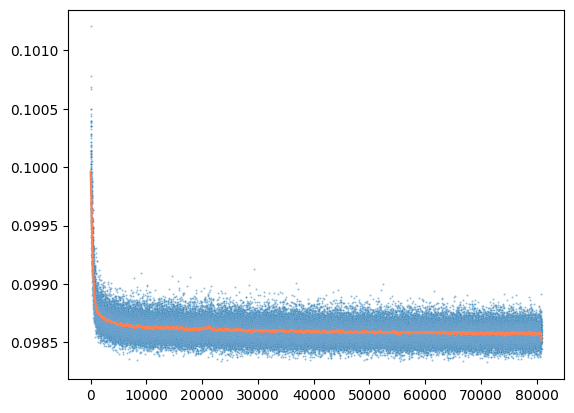

In [16]:
plot_loss(antipode_model.losses)

In [ ]:
antipode_model.store_outputs(device=device,prefix='')

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


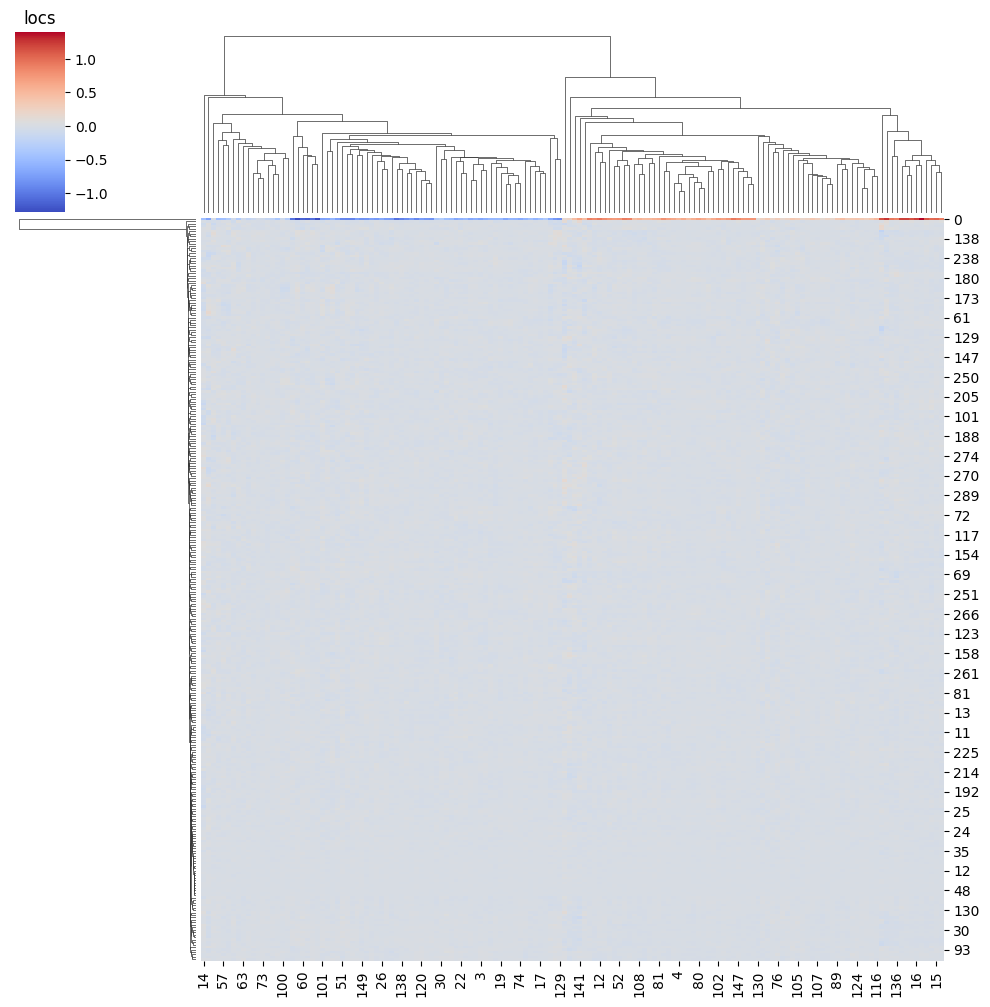

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


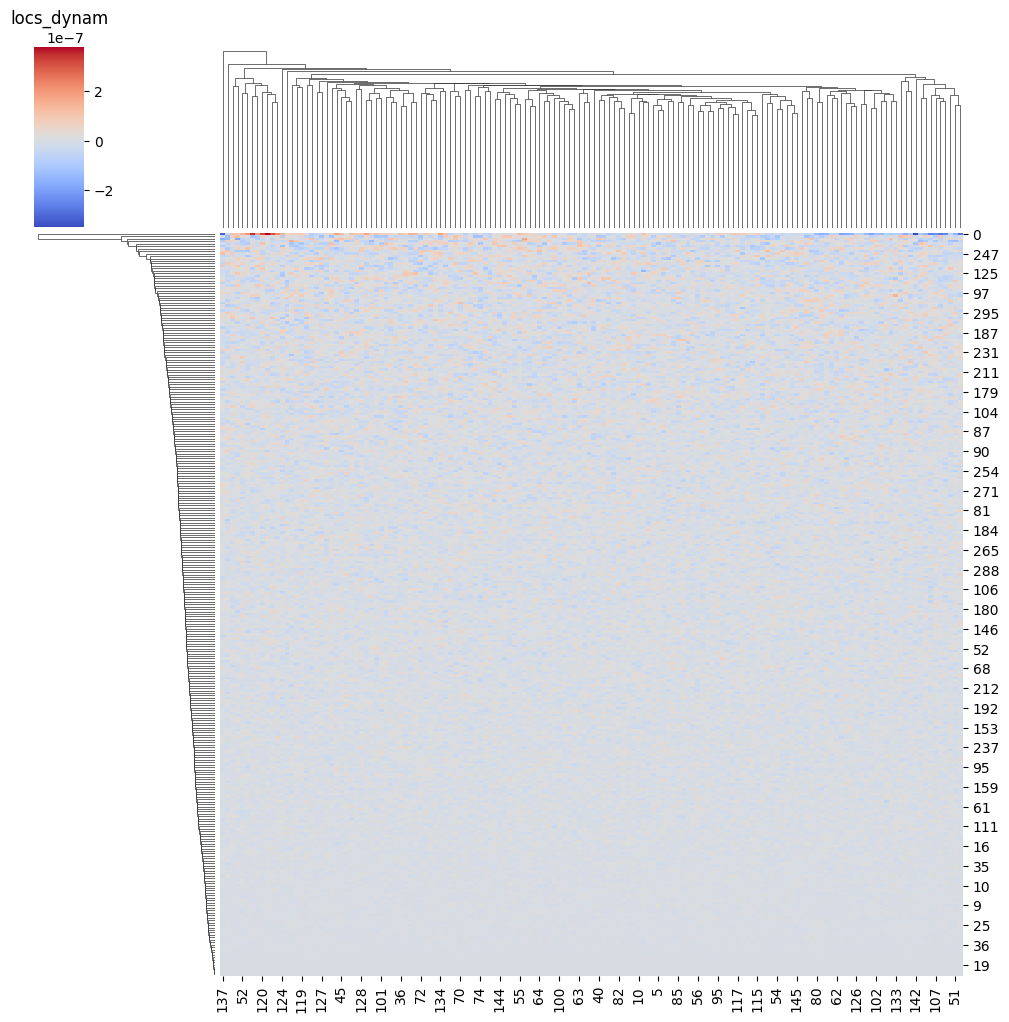

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


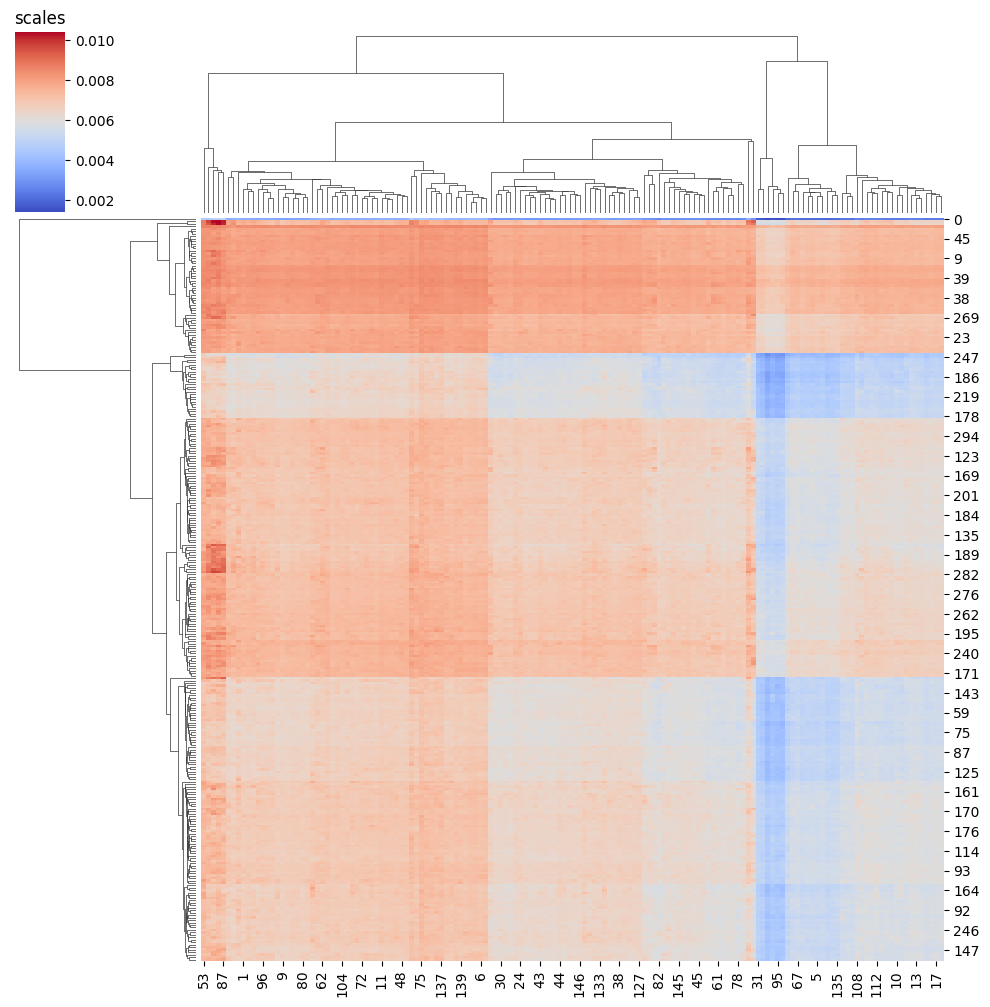

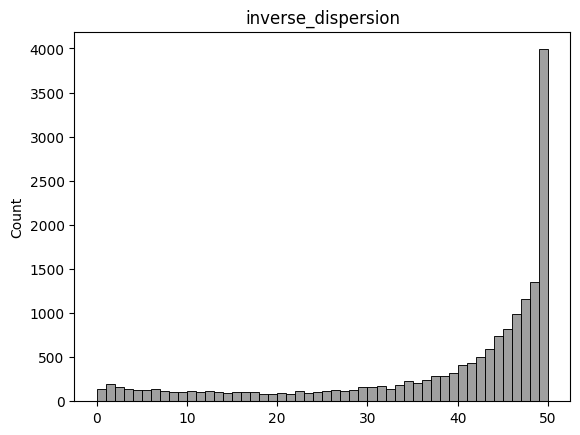

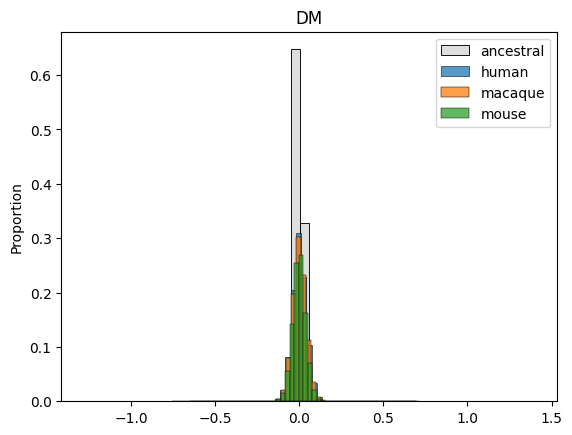

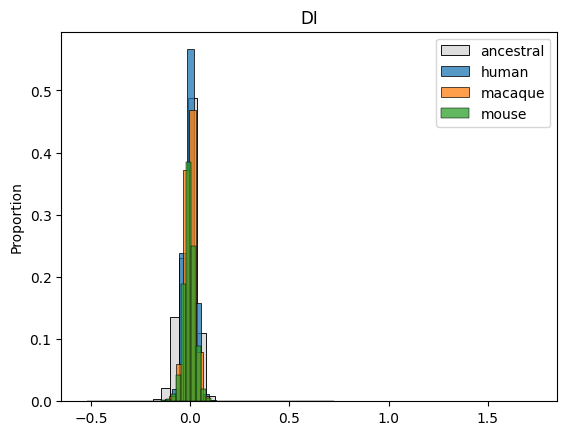

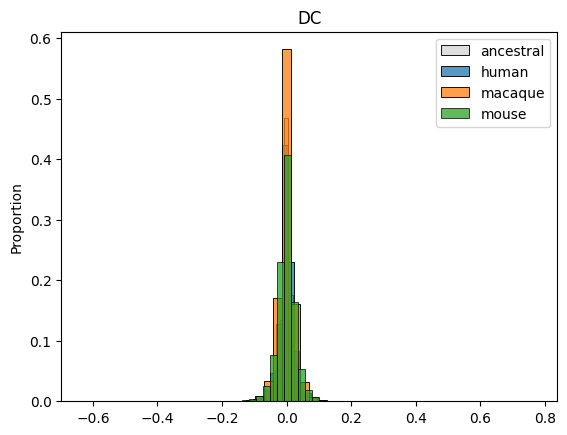

In [18]:
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Co

Mar 07 06:08:54 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Mar 07 06:08:54 PM: The following items have duplicates [2249895 2249897 2249899 2249900 2249901 2249904 2249905 2249908 2249909
 2249911 2249912 2249914 2249916 2249918 2249920 2249921 2249923 2249924
 2249926 2249928 2249929 2249930 2249933 2249935 2249938 2249939 2249941
 2249943 2249947 2249948 2249949 2249953 2249958 2249960 2249961 2249963
 2249965 2249966 2249967 2249970 2249971 2249972 2249978 2249979 2249982
 2249983 2249985 2249986 2249987 2249989 2249994 2249995 2249999 2250001
 2250003 2250010 2250011 2250013 2250014 2250016 2250019 2250021 2250023
 2250024 2250026 2250027 2250028 2250032 2250033 2250034 2250035 2250036
 2250037 2250039 2250040 2250043 2250045 2250053 2250054 2250055 2250057
 2250058 2250059 2250061 2250064 2250066 2250068 2250070 2250072 2250073
 2250074 2250077 2250078 2250080 2250082 2250085 2250086 2250087 2250088
 2250089

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


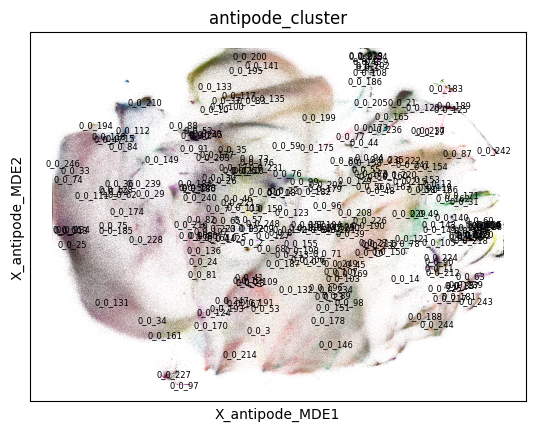

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


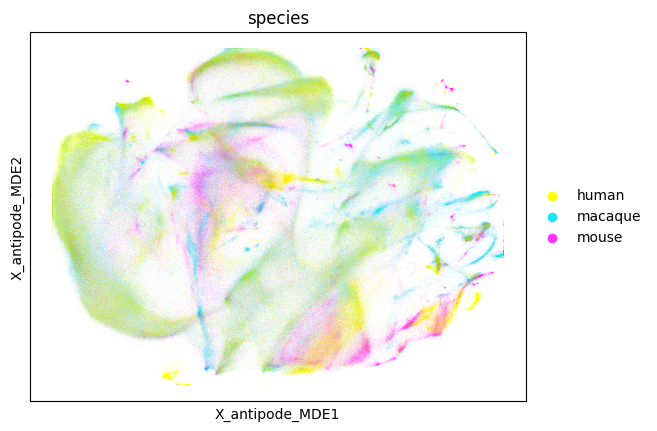

In [19]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_antipode']),0.1)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)


In [20]:
"""
random_choice=np.random.choice(adata.obs.index,size=20000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")
sc.tl.umap(xdata)
sc.pl.umap(xdata,color=['species'],use_raw=False,palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
"""
# xdata.X=xdata.layers['UMIs']
# sc.pp.normalize_per_cell(xdata)
# sc.pp.log1p(xdata)
# sc.pp.scale(xdata,max_value=10)
#sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
#sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
#sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


'\nrandom_choice=np.random.choice(adata.obs.index,size=20000,replace=False)\nrandom_choice=np.where(adata.obs.index.isin(random_choice))[0]\nxdata=adata[random_choice,:]\nxdata=xdata.to_memory().copy()\nsc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")\nsc.tl.umap(xdata)\nsc.pl.umap(xdata,color=[\'species\'],use_raw=False,palette=sc.pl.palettes.godsnot_102)\nsc.pl.umap(xdata,color=[\'psi\'],use_raw=False,legend_loc=\'on data\',cmap=\'coolwarm\')\nsc.pl.umap(xdata,color=[\'antipode_cluster\'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)\n'

# Training Phase 2: Inintializing categorical layered tree

In [21]:
antipode_model.prepare_phase_2()
adata.obs['kmeans']=adata.obs['kmeans'].astype('category')

INFO     Generating sequential column names                                                                        



100%|██████████| 250/250 [00:01<00:00, 201.01it/s]

100%|██████████| 250/250 [00:01<00:00, 133.91it/s]


In [23]:
antipode_model.train_phase(phase=2,max_steps=max_steps,print_every=10000,num_particles=3,device=device, max_learning_rate=0.0001, one_cycle_lr=False, batch_size=32)

  0%|          | 0/100000 [00:00<?, ?it/s]

nograd
tensor([[1.0000e+00, 8.6826e-03, 5.8466e-04,  ..., 1.1193e-07, 3.2410e-09,
         2.1127e-01],
        [1.0000e+00, 2.8268e-06, 8.1823e-06,  ..., 1.0602e-08, 6.1767e-07,
         1.9089e-08],
        [1.0000e+00, 3.4408e-01, 1.1158e-08,  ..., 1.2854e-10, 1.1661e-10,
         1.9117e-07],
        ...,
        [1.0000e+00, 4.0211e-05, 1.0110e-03,  ..., 3.5649e-08, 5.7041e-09,
         8.0617e-10],
        [1.0000e+00, 5.6190e-04, 2.0658e-02,  ..., 4.1873e-08, 4.4919e-08,
         1.1769e-08],
        [1.0000e+00, 6.1511e-05, 3.1688e-08,  ..., 1.4186e-09, 1.0000e-10,
         1.0902e-10]], device='cuda:0')
nograd
tensor([[1.0000e+00, 6.9999e-04, 8.5597e-04,  ..., 1.2195e-07, 1.9017e-10,
         2.8327e-01],
        [1.0000e+00, 2.2743e-04, 5.3947e-04,  ..., 8.6474e-09, 2.2031e-06,
         2.7698e-09],
        [1.0000e+00, 2.6950e-04, 2.5572e-03,  ..., 1.4439e-09, 2.0726e-10,
         4.5630e-06],
        ...,
        [1.0000e+00, 2.1723e-04, 4.7253e-06,  ..., 5.4793e-08, 2.6564

  0%|          | 1/100000 [00:00<11:40:54,  2.38it/s]

nograd
tensor([[1.0000e+00, 1.0912e-05, 5.1451e-01,  ..., 5.4924e-08, 3.6900e-10,
         3.7735e-01],
        [1.0000e+00, 5.2999e-08, 6.0635e-08,  ..., 9.3479e-09, 6.0390e-06,
         4.2057e-09],
        [1.0000e+00, 1.6700e-04, 3.8812e-04,  ..., 4.8737e-09, 7.2975e-08,
         1.3398e-05],
        ...,
        [1.0000e+00, 2.1340e-04, 6.1839e-03,  ..., 3.6384e-07, 1.4504e-09,
         5.4206e-09],
        [1.0000e+00, 9.1638e-06, 4.3628e-03,  ..., 4.2266e-09, 2.2223e-08,
         4.2119e-08],
        [1.0000e+00, 8.9821e-09, 3.0190e-08,  ..., 1.5764e-09, 1.0000e-10,
         1.0673e-10]], device='cuda:0', grad_fn=<CatBackward0>)
nograd
tensor([[1.0000e+00, 7.2662e-02, 2.8719e-01,  ..., 1.3886e-07, 6.2102e-10,
         5.4643e-01],
        [1.0000e+00, 7.2611e-07, 6.5160e-07,  ..., 1.5763e-08, 6.9526e-07,
         4.5534e-09],
        [1.0000e+00, 1.5287e-07, 1.7719e-06,  ..., 1.7833e-10, 1.5979e-10,
         9.9865e-07],
        ...,
        [1.0000e+00, 2.5985e-06, 1.5426e-03, 

/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15007384/ipykernel_64975/639271529.py:440: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

nograd
tensor([[1.0000e+00, 1.8558e-05, 9.4953e-05,  ..., 5.2458e-08, 2.6050e-08,
         8.8560e-02],
        [1.0000e+00, 2.1384e-04, 2.0025e-07,  ..., 2.7015e-07, 1.1757e-06,
         6.6892e-08],
        [1.0000e+00, 1.5030e-09, 2.3369e-08,  ..., 1.4485e-10, 1.3584e-10,
         1.7182e-07],
        ...,
        [1.0000e+00, 6.7984e-07, 4.5083e-08,  ..., 3.2446e-09, 3.9977e-09,
         1.3349e-10],
        [1.0000e+00, 2.4388e-07, 2.9788e-06,  ..., 1.5466e-09, 2.2627e-09,
         1.2099e-07],
        [1.0000e+00, 3.8350e-09, 2.8511e-10,  ..., 3.6153e-10, 1.0001e-10,
         9.0116e-10]], device='cuda:0', grad_fn=<CatBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15007384/ipykernel_64975/639271529.py:343: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

nograd
tensor([[1.0000e+00, 1.4366e-03, 1.4044e-03,  ..., 9.5876e-09, 1.7570e-10,
         4.8023e-04],
        [1.0000e+00, 6.5416e-08, 2.2498e-04,  ..., 2.3946e-09, 6.0095e-05,
         3.9057e-09],
        [1.0000e+00, 2.4465e-06, 1.0256e-04,  ..., 1.4208e-09, 1.8111e-09,
         3.1009e-05],
        ...,
        [1.0000e+00, 1.2160e-06, 2.9714e-07,  ..., 8.1352e-09, 9.6997e-10,
         1.2352e-10],
        [1.0000e+00, 1.5151e-04, 6.6514e-01,  ..., 2.0331e-08, 7.8422e-10,
         1.6925e-08],
        [1.0000e+00, 1.4486e-09, 2.4381e-03,  ..., 4.9452e-09, 1.0050e-10,
         1.5235e-09]], device='cuda:0', grad_fn=<CatBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15007384/ipykernel_64975/639271529.py:343: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

nograd
tensor([[1.0000e+00, 1.0268e-06, 1.5258e-07,  ..., 2.3351e-08, 1.0832e-10,
         2.0237e-02],
        [1.0000e+00, 7.4019e-09, 1.0848e-03,  ..., 1.4071e-08, 1.4698e-05,
         9.6823e-09],
        [1.0000e+00, 4.2613e-03, 2.7432e-05,  ..., 1.5677e-09, 4.1747e-10,
         5.8157e-07],
        ...,
        [1.0000e+00, 1.1378e-07, 6.1955e-07,  ..., 3.1553e-09, 1.2799e-08,
         1.6382e-09],
        [1.0000e+00, 6.4303e-07, 3.3805e-07,  ..., 2.1887e-08, 3.3275e-10,
         4.5227e-10],
        [1.0000e+00, 1.2552e-03, 2.0096e-03,  ..., 2.3541e-10, 1.0052e-10,
         4.1126e-09]], device='cuda:0', grad_fn=<CatBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15007384/ipykernel_64975/639271529.py:343: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

[Step 10000]  Loss: 0.10004


 16%|█▌        | 15783/100000 [48:10<4:05:20,  5.72it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 20%|██        | 20002/100000 [1:00:31<4:09:40,  5.34it/s]

[Step 20000]  Loss: 0.10000


 30%|███       | 30002/100000 [1:29:58<3:24:54,  5.69it/s]

[Step 30000]  Loss: 0.09998


 31%|███       | 30596/100000 [1:31:42<3:23:09,  5.69it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 40%|████      | 40002/100000 [1:59:38<2:58:42,  5.60it/s]

[Step 40000]  Loss: 0.09997


 50%|█████     | 50002/100000 [2:29:22<2:26:18,  5.70it/s]

[Step 50000]  Loss: 0.09997


 55%|█████▍    | 54850/100000 [2:43:39<2:12:11,  5.69it/s]
KeyboardInterrupt



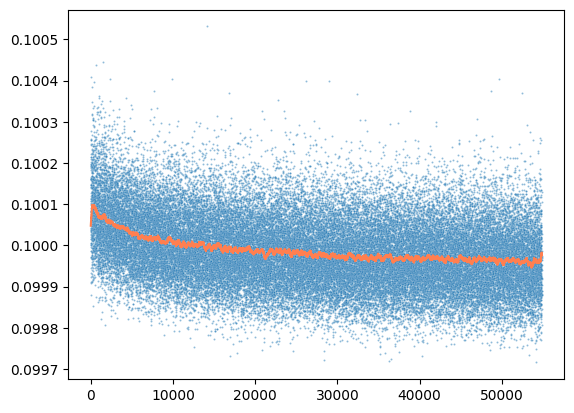

In [24]:
plot_loss(antipode_model.losses)

In [25]:
antipode_model.store_outputs(device=device,prefix='')


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


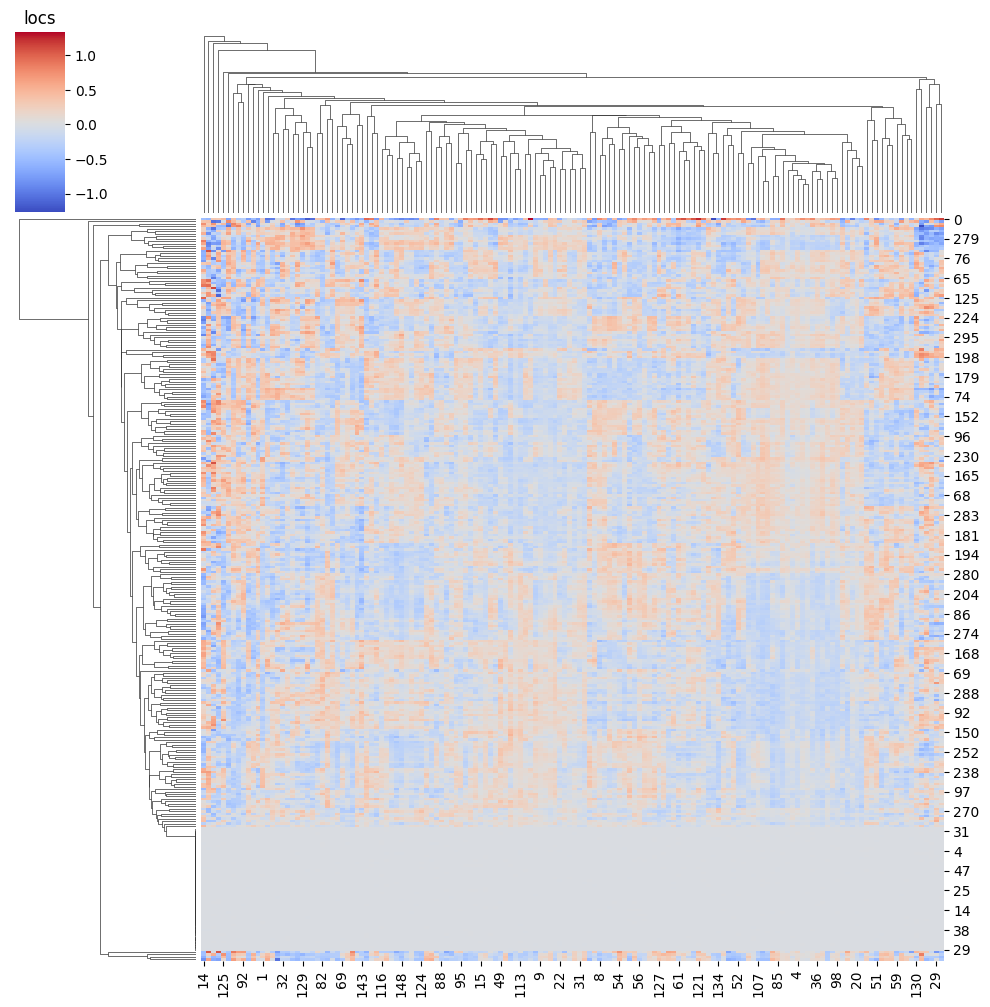

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


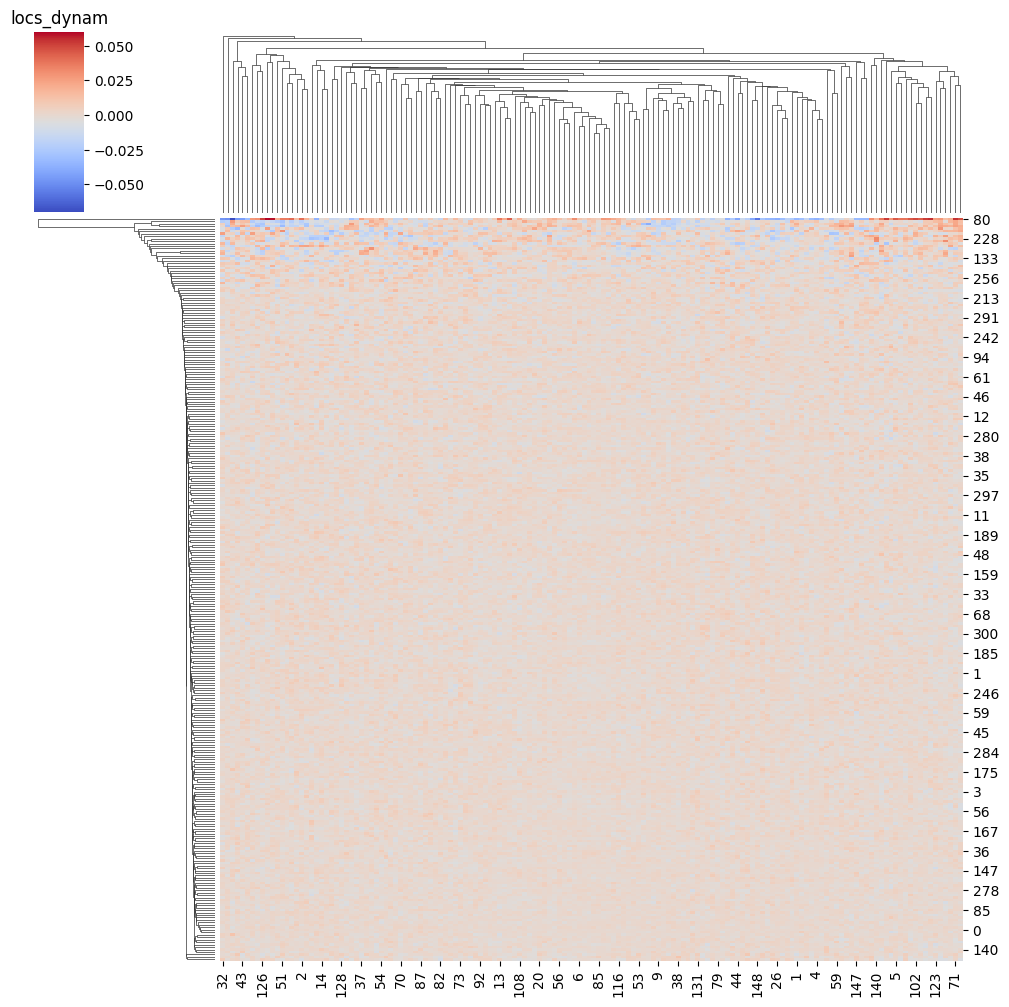

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


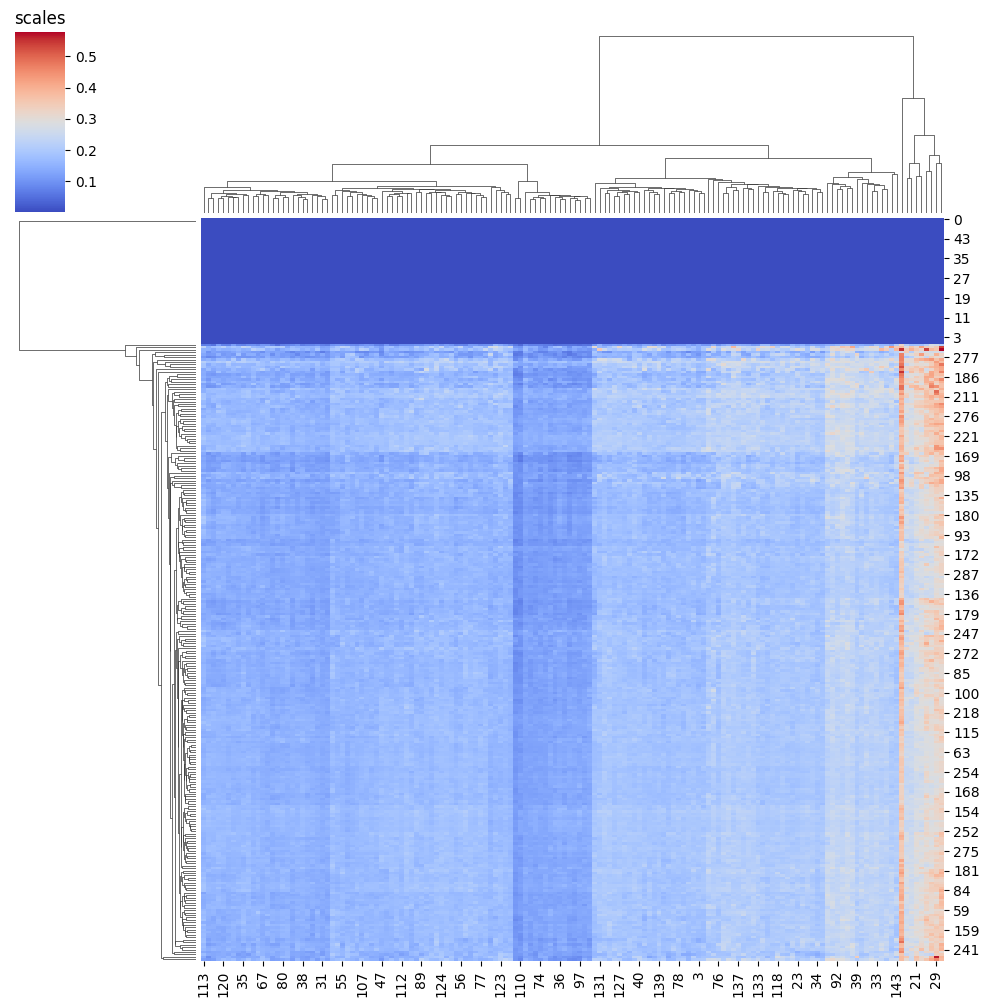

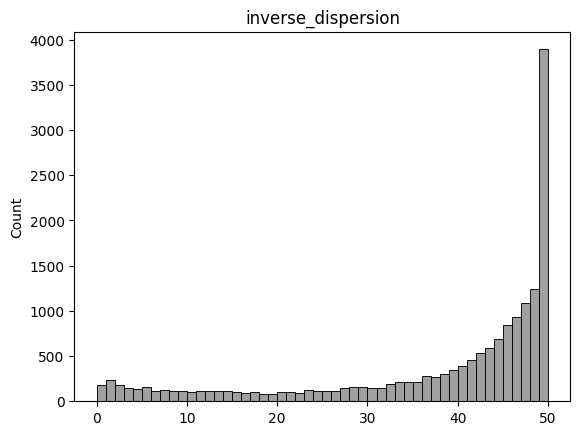

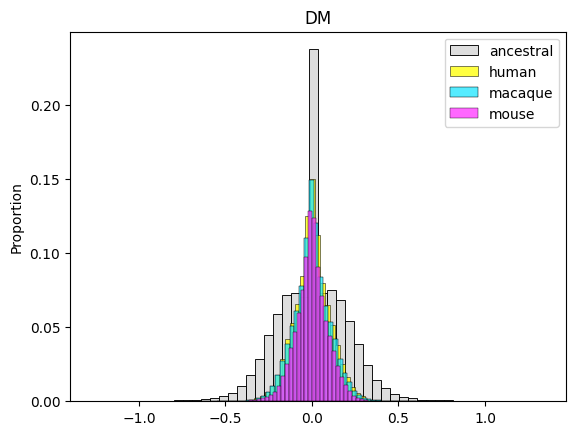

  0%|          | 3/100000 [2:48:48<93780:15:33, 3376.19s/it]


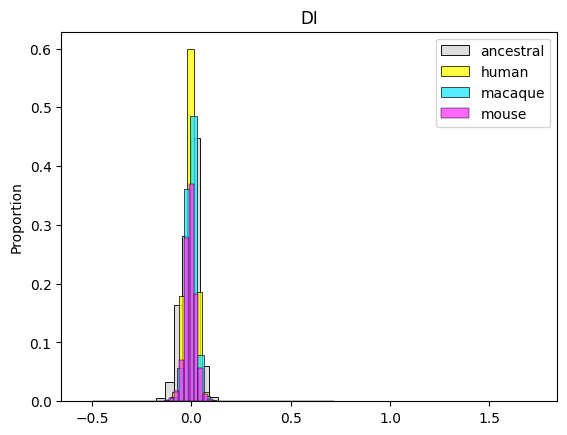

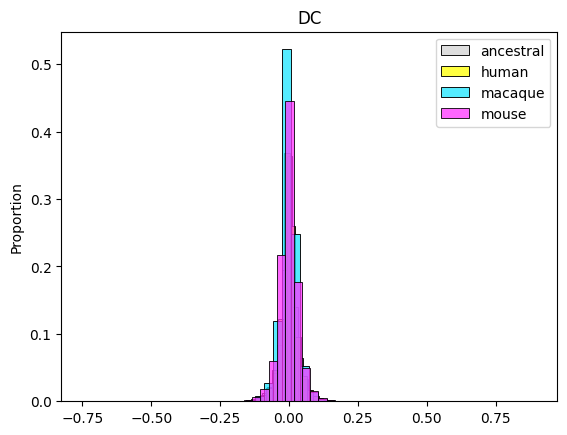

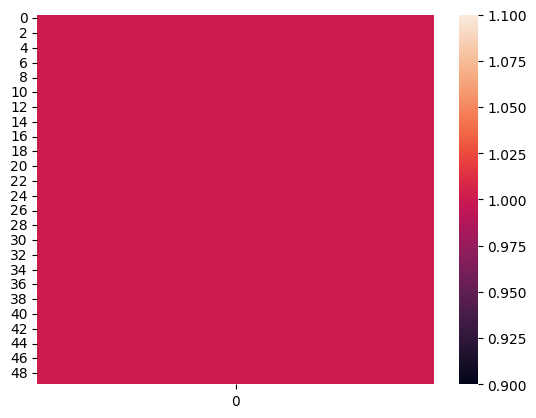

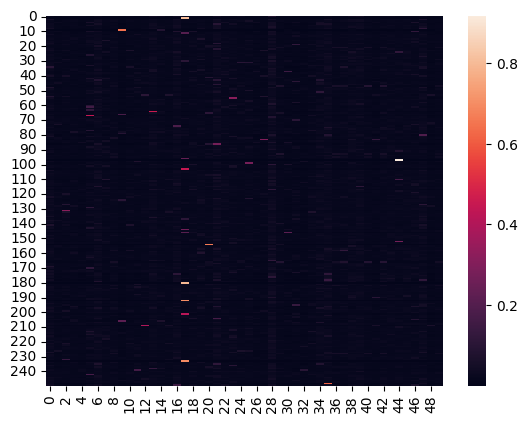

In [26]:
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_tree_edge_weights(antipode_model)

Mar 07 09:07:33 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Mar 07 09:07:33 PM: The following items have duplicates [2249895 2249896 2249897 ... 2251910 2251912 2251914]


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


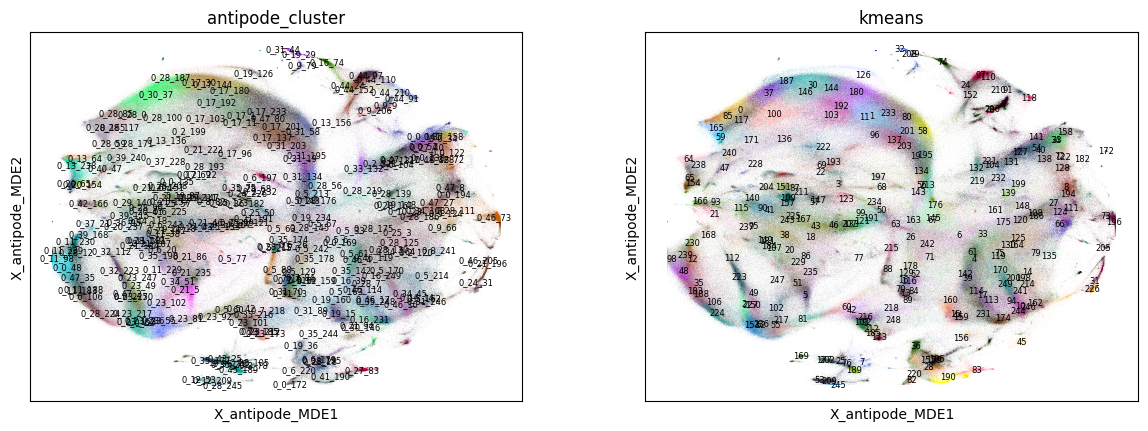

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


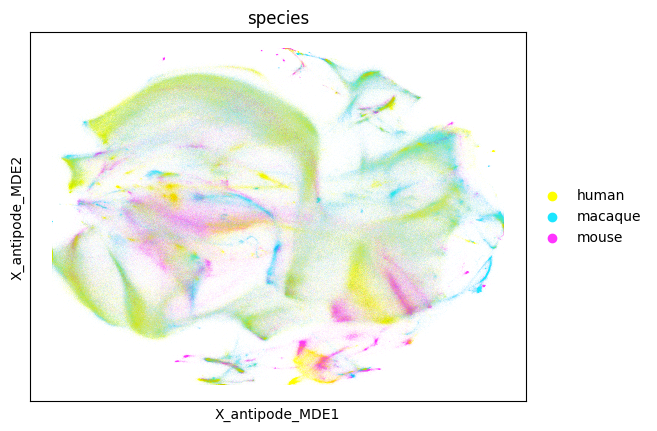

In [27]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_antipode']),0.1)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","kmeans"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/utils/miniconda3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

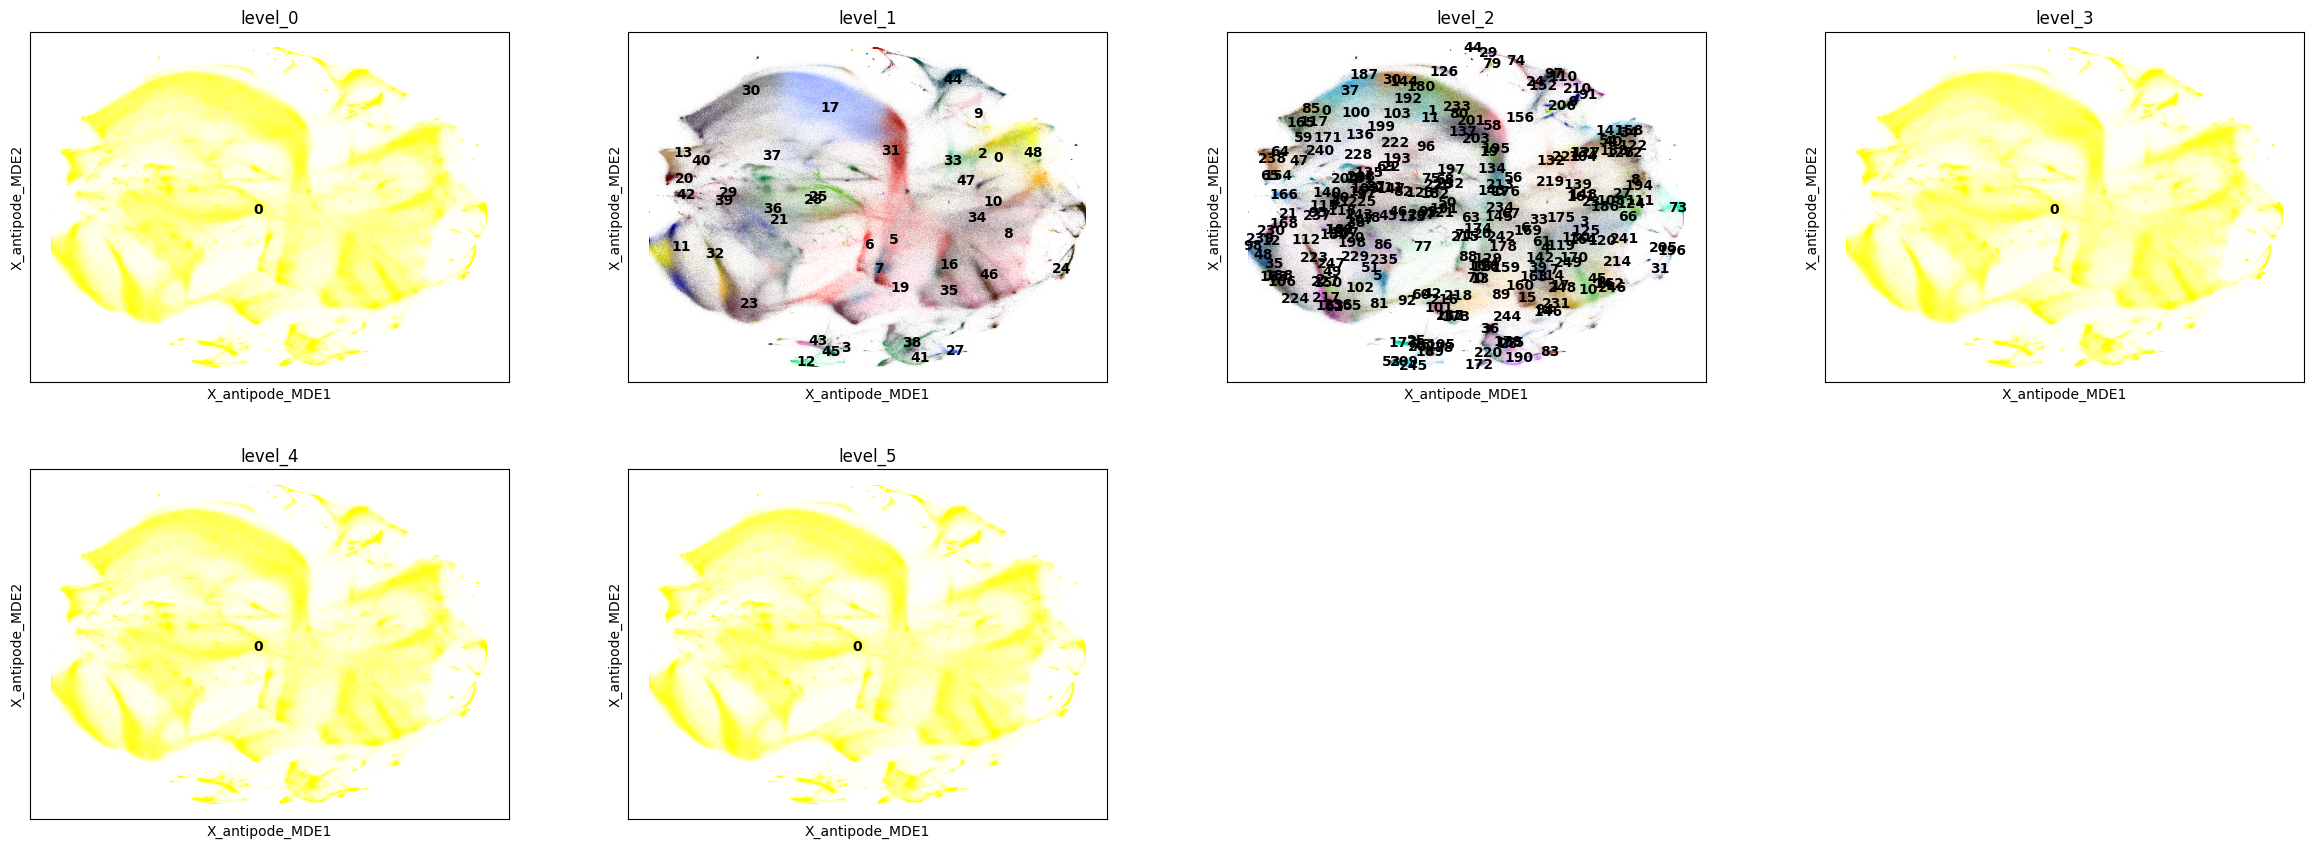


KeyboardInterrupt



In [28]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["psi"],
    cmap='coolwarm'
)


In [ ]:
"""
random_choice=np.random.choice(adata.obs.index,size=10000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")
sc.tl.umap(xdata)
sc.pl.umap(xdata,color=['species'],use_raw=False,legend_loc='on data',palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,legend_loc='on data',cmap='coolwarm')
sc.pl.umap(xdata,color=['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
"""
# xdata.X=xdata.layers['UMIs']
# sc.pp.normalize_per_cell(xdata)
# sc.pp.log1p(xdata)
# sc.pp.scale(xdata,max_value=10)
#sc.pl.umap(xdata,color=['GBX2','EOMES','SIX3','OTX2','FOXG1','RBFOX3','TH','PDGFRA','AQP4','FOXJ1','AIF1','TTR','MOG','COL1A2','CD34','COL4A1','NPY','NKX2-1','FOXP2','SATB2','RORB','FEZF2','EMX1'],use_raw=False,cmap='Purples')
#sc.pl.umap(xdata,color=['DLX2','PROX1','SCGN','TSHZ1','MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67'],cmap='Purples',use_raw=False)
#sc.pl.umap(xdata,color=['RPL7','RPS17','RPL13A','MEF2C'],cmap='Purples',use_raw=False)


# Training Phase 3: Refining the final tree

In [ ]:
antipode_model.train_phase(phase=3,max_steps=max_steps,print_every=10000,num_particles=5,device=device, max_learning_rate=1e-4, one_cycle_lr=True, steps=0, batch_size=32)

  0%|          | 0/100000 [00:00<?, ?it/s]

tensor([[1.0000e+00, 2.5559e-05, 3.3395e-05,  ..., 1.7157e-03, 2.9737e-05,
         2.0410e-05],
        [1.0000e+00, 2.7178e-07, 7.0507e-06,  ..., 1.7899e-08, 2.8527e-02,
         8.5882e-02],
        [1.0000e+00, 2.3977e-02, 2.9270e-04,  ..., 2.3052e-09, 3.8371e-09,
         1.1148e-09],
        ...,
        [1.0000e+00, 5.9373e-03, 4.6214e-03,  ..., 2.1990e-10, 1.4849e-10,
         1.1420e-10],
        [1.0000e+00, 2.5038e-02, 1.8286e-03,  ..., 4.8427e-05, 7.6705e-06,
         3.5270e-07],
        [1.0000e+00, 2.5557e-02, 1.5991e-05,  ..., 9.9164e-05, 2.6091e-01,
         1.6729e-02]], device='cuda:0')
tensor([[1.0000e+00, 1.7591e-03, 4.4018e-05,  ..., 1.3884e-04, 3.5786e-05,
         4.5890e-05],
        [1.0000e+00, 1.7381e-03, 5.1149e-05,  ..., 7.6018e-08, 1.5937e-02,
         8.9428e-02],
        [1.0000e+00, 3.4240e-03, 1.9104e-03,  ..., 2.5610e-09, 3.3262e-09,
         3.5041e-09],
        ...,
        [1.0000e+00, 5.6841e-04, 2.5251e-03,  ..., 2.6818e-10, 2.0796e-10,
        

  0%|          | 1/100000 [00:00<14:29:41,  1.92it/s]

tensor([[1.0000e+00, 2.8544e-04, 8.1364e-05,  ..., 1.1480e-03, 7.4508e-05,
         3.3937e-05],
        [1.0000e+00, 1.3692e-03, 6.8324e-04,  ..., 1.4574e-08, 7.0613e-03,
         1.2694e-01],
        [1.0000e+00, 4.0628e-03, 5.8753e-06,  ..., 8.5376e-10, 9.3515e-10,
         1.0693e-09],
        ...,
        [1.0000e+00, 3.7386e-05, 4.0114e-06,  ..., 1.1825e-10, 1.1083e-10,
         1.0141e-10],
        [1.0000e+00, 8.5380e-02, 4.2076e-04,  ..., 6.1878e-04, 4.2728e-05,
         7.5596e-06],
        [1.0000e+00, 3.6877e-05, 4.3373e-04,  ..., 7.5047e-06, 9.6861e-03,
         5.4037e-04]], device='cuda:0')
tensor([[1.0000e+00, 2.6865e-03, 1.2205e-04,  ..., 8.6673e-05, 5.0000e-05,
         2.5406e-05],
        [1.0000e+00, 1.2308e-04, 1.5624e-02,  ..., 3.7233e-07, 6.0883e-02,
         3.0946e-01],
        [1.0000e+00, 9.0961e-02, 9.8498e-04,  ..., 2.1246e-09, 8.3666e-09,
         1.3524e-08],
        ...,
        [1.0000e+00, 4.5395e-01, 6.4675e-06,  ..., 1.0367e-10, 1.0170e-10,
        

/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15007384/ipykernel_64975/639271529.py:440: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

tensor([[1.0000e+00, 4.7174e-04, 4.6426e-04,  ..., 1.1481e-05, 8.7959e-06,
         5.4745e-06],
        [1.0000e+00, 2.8102e-05, 2.0366e-04,  ..., 1.1556e-07, 3.1700e-02,
         3.9441e-01],
        [1.0000e+00, 2.1763e-05, 8.1725e-04,  ..., 6.2382e-09, 1.4368e-08,
         5.7734e-09],
        ...,
        [1.0000e+00, 5.3727e-04, 3.2090e-04,  ..., 1.9698e-10, 1.8590e-10,
         1.3094e-10],
        [1.0000e+00, 9.0580e-02, 9.8129e-04,  ..., 1.6215e-03, 1.4845e-04,
         1.2119e-05],
        [1.0000e+00, 8.0721e-04, 1.3734e-04,  ..., 7.3250e-04, 2.0400e-01,
         2.9294e-02]], device='cuda:0', grad_fn=<CatBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15007384/ipykernel_64975/639271529.py:343: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

tensor([[1.0000e+00, 8.9610e-03, 5.1119e-01,  ..., 1.3906e-03, 1.4757e-04,
         2.0012e-04],
        [1.0000e+00, 2.5107e-02, 1.7838e-02,  ..., 4.2415e-08, 2.6041e-02,
         2.1187e-01],
        [1.0000e+00, 4.3411e-03, 4.3974e-04,  ..., 3.2341e-09, 7.7023e-09,
         1.9876e-09],
        ...,
        [1.0000e+00, 1.9551e-01, 2.7603e-05,  ..., 2.3839e-10, 3.9813e-10,
         1.4704e-10],
        [1.0000e+00, 8.0897e-03, 7.6653e-04,  ..., 2.8188e-04, 2.7172e-06,
         5.1619e-07],
        [1.0000e+00, 4.4119e-03, 2.7120e-03,  ..., 1.7477e-04, 2.9759e-02,
         5.3278e-03]], device='cuda:0', grad_fn=<CatBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15007384/ipykernel_64975/639271529.py:343: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

tensor([[1.0000e+00, 6.8779e-04, 1.0505e-01,  ..., 1.5934e-04, 8.8203e-06,
         5.9503e-06],
        [1.0000e+00, 2.7029e-02, 2.6854e-01,  ..., 2.0662e-07, 7.8135e-02,
         3.6866e-01],
        [1.0000e+00, 9.4015e-03, 5.5828e-04,  ..., 2.5807e-10, 1.1981e-09,
         4.8486e-10],
        ...,
        [1.0000e+00, 4.4436e-01, 3.4307e-04,  ..., 5.8186e-10, 2.0457e-10,
         1.1108e-10],
        [1.0000e+00, 1.8616e-03, 2.3726e-02,  ..., 2.2393e-04, 3.6724e-05,
         2.3869e-06],
        [1.0000e+00, 1.1440e-03, 4.4355e-04,  ..., 8.2461e-04, 4.6488e-02,
         1.1274e-02]], device='cuda:0', grad_fn=<CatBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15007384/ipykernel_64975/639271529.py:343: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

tensor([[1.0000e+00, 2.7061e-05, 3.8031e-04,  ..., 2.4601e-05, 3.0929e-05,
         1.4408e-05],
        [1.0000e+00, 5.4094e-05, 3.7470e-03,  ..., 1.1067e-08, 2.9382e-02,
         1.6247e-01],
        [1.0000e+00, 5.3200e-04, 1.4214e-01,  ..., 2.1665e-09, 4.8459e-09,
         1.3189e-09],
        ...,
        [1.0000e+00, 4.9271e-03, 2.2648e-03,  ..., 1.1172e-09, 6.1149e-10,
         3.5949e-10],
        [1.0000e+00, 1.5597e-02, 1.0564e-03,  ..., 2.0062e-03, 6.2711e-05,
         7.5035e-06],
        [1.0000e+00, 1.2980e-03, 2.7354e-03,  ..., 5.7497e-05, 2.0168e-01,
         5.6878e-03]], device='cuda:0', grad_fn=<CatBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15007384/ipykernel_64975/639271529.py:343: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

tensor([[1.0000e+00, 2.3044e-03, 4.2505e-03,  ..., 7.2853e-05, 4.0187e-05,
         4.2442e-05],
        [1.0000e+00, 7.2889e-02, 1.7193e-05,  ..., 2.5547e-07, 2.0309e-02,
         3.0473e-01],
        [1.0000e+00, 2.7857e-04, 3.0379e-03,  ..., 6.5817e-09, 4.0409e-08,
         1.9403e-08],
        ...,
        [1.0000e+00, 2.4551e-04, 5.9320e-03,  ..., 1.2808e-10, 1.8080e-10,
         1.1171e-10],
        [1.0000e+00, 1.5107e-01, 8.0917e-03,  ..., 6.0314e-04, 1.4454e-04,
         3.6536e-06],
        [1.0000e+00, 8.0987e-04, 2.4353e-05,  ..., 1.2783e-04, 4.6231e-01,
         3.2562e-03]], device='cuda:0', grad_fn=<CatBackward0>)


/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:212: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sum(index.shape) == 1:
/home/matthew.schmitz/Matthew/code/scANTIPODE/antipode/model_functions.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  index=torch.nn.functional.one_hot(index.squeeze(),num_classes=out_shape[1]).float() if index.shape[-1]==1 else index
/scratch/fast/15007384/ipykernel_64975/639271529.py:343: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't recor

In [ ]:
plot_loss(antipode_model.losses)

In [ ]:
antipode_model.store_outputs(device=device,prefix='')

In [ ]:
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_tree_edge_weights(antipode_model)

In [ ]:
MDE_KEY = "X_antipode_MDE"
adata.obsm[MDE_KEY] = clip_latent_dimensions(scvi.model.utils.mde(adata.obsm['X_antipode']),0.1)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster","kmeans"],legend_fontsize=6,legend_fontweight='normal',
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["species"],palette=sc.pl.palettes.godsnot_102
)


In [ ]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["psi"],
    cmap='coolwarm'
)


In [ ]:
#sc.pl.umap(adata,color=[x for x in adata.obs.columns if 'level' in x]+['antipode_cluster','kmeans'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)

random_choice=np.random.choice(adata.obs.index,size=100000,replace=False)
random_choice=np.where(adata.obs.index.isin(random_choice))[0]
xdata=adata[random_choice,:]
xdata=xdata.to_memory().copy()
"""
sc.pp.neighbors(xdata,n_neighbors=20, use_rep="X_antipode")
sc.tl.umap(xdata)

sc.pl.umap(xdata,color=['species'],use_raw=False,palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(xdata,color=['psi'],use_raw=False,cmap='coolwarm')
sc.pl.umap(xdata,color=['antipode_cluster'],use_raw=False,legend_loc=None,palette=sc.pl.palettes.godsnot_102)
"""
# xdata.X=xdata.layers['UMIs'].todense()
# sc.pp.normalize_per_cell(xdata)
# sc.pp.log1p(xdata)
# sc.pp.scale(xdata,max_value=10)
#sc.pl.umap(xdata,color=gene_list,cmap='Purples',use_raw=False)


In [ ]:
xdata.X=xdata.raw.X.todense()[:,xdata.raw.var.index.isin(xdata.var.index)]
sc.pp.normalize_per_cell(xdata)
sc.pp.log1p(xdata)
#sc.pp.scale(xdata,max_value=10)

gene_list=['RBFOX3','PDGFRA','AQP4','FOXJ1','AIF1','MOG','COL1A2','CD34','COL4A1','SATB2','RORB','DLX2','PROX1','SCGN','TSHZ1','SLC17A7','TLE4','FEZF2',
           'MEIS2','NKX2-1','LHX6','CRABP1','TSHZ1','NPY','FOXP1','FOXP2','PDYN','PENK','ISL1','FOXG1','PDGFRA','AIF1','AQP4','EDNRB','FOXJ1','CD34','MKI67','RPL7','RPS17','RPL13A','MEF2C']
gene_list=[x for x in gene_list if x in xdata.var.index]
sc.pl.embedding(
    xdata,
    basis=MDE_KEY,
    color=gene_list,cmap='Purples',
    palette=sc.pl.palettes.godsnot_102,legend_fontsize=6,
    legend_loc='on data',use_raw=False
)


In [ ]:
xdata.X=xdata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]

In [ ]:
#xdata.write_h5ad('/home/matthew.schmitz/Matthew/1.9.4_devbigger.h5ad')

In [ ]:
#xdata=sc.read_h5ad('/home/matthew.schmitz/Matthew/1.9.4_devbigger.h5ad')